<a href="https://colab.research.google.com/github/dcastf01/adversarial_project/blob/main/Extract_IRT_params_from_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
!pip install pytorch-pfn-extras timm
!pip install pytorch-ignite
!pip3 install --upgrade Pillow


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.1.2)


In [2]:

%reload_ext autoreload
%autoreload

In [3]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
  
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.4.1
Running on  1  GPU(s) 
Number of accelerators:  1


In [4]:
!nvidia-smi

Wed Mar 10 09:38:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    59W / 149W |    124MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!git clone https://github.com/dcastf01/colab_utils.git
!git clone https://github.com/dcastf01/adversarial_project.git

Cloning into 'colab_utils'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 152 (delta 85), reused 30 (delta 14), pack-reused 0
Receiving objects: 100% (152/152), 163.61 KiB | 2.04 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Cloning into 'adversarial_project'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 164 (delta 58), reused 116 (delta 27), pack-reused 0
Receiving objects: 100% (164/164), 1.87 MiB | 9.59 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [6]:
#@title Texto de título predeterminado
csv_with_info= "/content/IRT.csv" #@param {type:"string"}

root_dir= "/content/dataset" #@param {type:"string"}

In [7]:
from colab_utils.utils.download_files import download_file_from_google_drive
import os
from adversarial_project.data.IRT_features.dict_with_id_drive import id_drive_to_download
import shutil

In [8]:
for name_file,id in id_drive_to_download.ids_dataset.items():
    if name_file[-4:]==".zip":
      name_folder=name_file[:-4].split("_")[-1]
      name_folder=os.path.join(root_dir, name_folder)
      os.makedirs(name_folder,exist_ok=True)
      download_file_from_google_drive(id,destination=name_file)
      !unzip {name_file} -d {name_folder}        

    else:

      download_file_from_google_drive(id,destination=name_file)


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000215.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000225.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000235.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000245.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000255.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000265.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000275.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000285.png  
  inflating: /content/dataset/05/result_adversarial0.5/pert_eps_0.5_ILSVRC2012_val_00000295.png  
  inflating: /content/dataset/05/result_adversarial0.5/pe

In [9]:
import os
import timm
import shutil
from torchvision import datasets
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

import torch
from torchvision import datasets
from torch.utils.data import (
    Dataset,
    DataLoader,

) 


#create csv and check data

In [10]:
from adversarial_project.concat_csv_files import concat_csv_files
import pandas as pd

In [11]:

df=concat_csv_files(os.path.join(root_dir,"IRT")).sort_values("Dffclt")
df.pert=df.pert.astype('str')
print(df)
df.to_csv(csv_with_info,index=False,)

                     filename       Dffclt    Dscrmn pert
4725  ILSVRC2012_val_00028905  -684.426330  0.002352    0
5353  ILSVRC2012_val_00014965  -638.269815  0.003258    0
2629  ILSVRC2012_val_00002765  -543.349974 -0.005214  025
639   ILSVRC2012_val_00002535  -333.132420 -0.001357  002
2219  ILSVRC2012_val_00009495  -234.641317 -0.012074   05
...                       ...          ...       ...  ...
4120  ILSVRC2012_val_00040975  3453.528411  0.000820    0
3894  ILSVRC2012_val_00025105  3453.528411  0.000820    0
3949  ILSVRC2012_val_00038925  3453.528411  0.000820    0
4000  ILSVRC2012_val_00010975  3453.528411 -0.000820    0
3902  ILSVRC2012_val_00040865  3453.528411 -0.000820    0

[7107 rows x 4 columns]


In [12]:
df = pd.read_csv("IRT.csv", index_col=False, header=0,converters={'pert': lambda x: str(x)})
print(df)

                     filename       Dffclt    Dscrmn pert
0     ILSVRC2012_val_00028905  -684.426330  0.002352    0
1     ILSVRC2012_val_00014965  -638.269815  0.003258    0
2     ILSVRC2012_val_00002765  -543.349974 -0.005214  025
3     ILSVRC2012_val_00002535  -333.132420 -0.001357  002
4     ILSVRC2012_val_00009495  -234.641317 -0.012074   05
...                       ...          ...       ...  ...
7102  ILSVRC2012_val_00040975  3453.528411  0.000820    0
7103  ILSVRC2012_val_00025105  3453.528411  0.000820    0
7104  ILSVRC2012_val_00038925  3453.528411  0.000820    0
7105  ILSVRC2012_val_00010975  3453.528411 -0.000820    0
7106  ILSVRC2012_val_00040865  3453.528411 -0.000820    0

[7107 rows x 4 columns]


In [13]:
df[df["pert"]==0]

,filename,Dffclt,Dscrmn,pert


In [14]:
import matplotlib.pyplot as plt


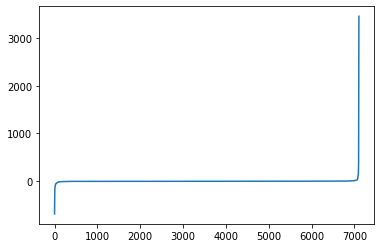

In [15]:
plt.plot(df.Dffclt)

(array([4.000e+00, 7.087e+03, 9.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([-684.42633032, -270.63085618,  143.16461795,  556.96009209,
         970.75556623, 1384.55104036, 1798.3465145 , 2212.14198863,
        2625.93746277, 3039.7329369 , 3453.52841104]),
 <a list of 10 Patch objects>)

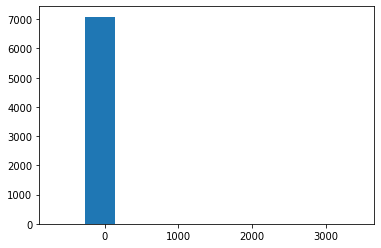

In [16]:
plt.hist(df.Dffclt)

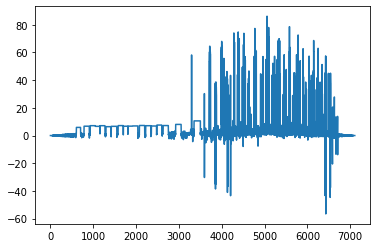

In [17]:
plt.plot(df.Dscrmn)

(array([5.000e+00, 9.000e+00, 2.000e+00, 1.207e+03, 5.445e+03, 3.700e+01,
        1.450e+02, 1.150e+02, 1.260e+02, 1.600e+01]),
 array([-56.59322407, -42.31869189, -28.0441597 , -13.76962752,
          0.50490466,  14.77943685,  29.05396903,  43.32850122,
         57.6030334 ,  71.87756559,  86.15209777]),
 <a list of 10 Patch objects>)

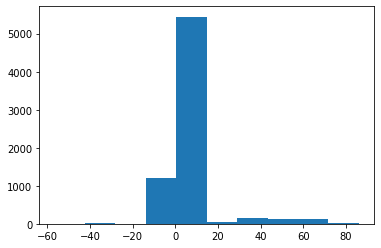

In [18]:
plt.hist(df.Dscrmn)

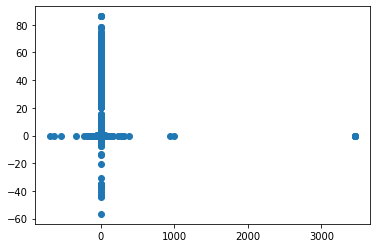

In [19]:
plt.scatter(x=df.Dffclt,y=df.Dscrmn)

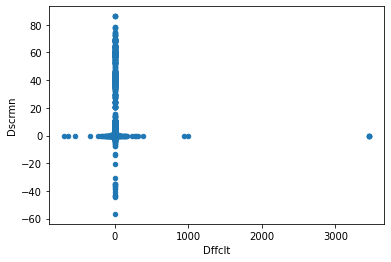

In [20]:
df.plot(x="Dffclt",y="Dscrmn", kind="scatter")

In [21]:
df.describe()

,Dffclt,Dscrmn
count,7107.000000,7107.000000
mean,1.491728,6.020199
std,94.860222,11.947293
min,-684.426330,-56.593224
25%,-2.038179,0.796063
50%,-1.420947,2.326422
75%,-0.104210,6.888626
max,3453.528411,86.152098


Eliminamos los valores que no están entre menos diez y mas dias

In [22]:
df=df[(df["Dffclt"]>=-10)& (df["Dffclt"]<=10) ]
df.to_csv(csv_with_info,index=False,)

In [23]:
df.describe()

,Dffclt,Dscrmn
count,6837.000000,6837.000000
mean,-0.938130,6.257588
std,1.936119,12.119872
min,-9.800157,-56.593224
25%,-2.036290,0.900095
50%,-1.419809,2.570652
75%,-0.158068,6.936234
max,9.864085,86.152098


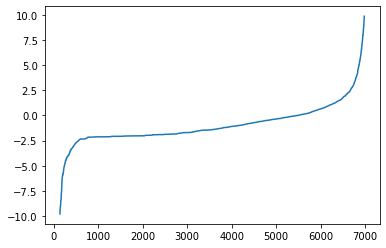

In [24]:
plt.plot(df.Dffclt)

(array([  31.,   35.,  137., 1877., 3300., 1037.,  251.,   87.,   47.,
          35.]),
 array([-9.80015651, -7.8337324 , -5.86730829, -3.90088419, -1.93446008,
         0.03196403,  1.99838813,  3.96481224,  5.93123635,  7.89766045,
         9.86408456]),
 <a list of 10 Patch objects>)

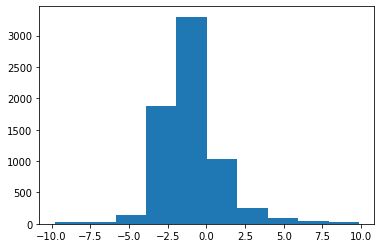

In [25]:
plt.hist(df.Dffclt)

#dataset pytorch

In [79]:
from torchvision.datasets.folder import default_loader
from torch.nn import functional as F
from scipy import special
import matplotlib.pyplot as plt
class IRTFeaturesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_info = pd.read_csv(csv_file,converters={'pert': lambda x: str(x)})
        self.root_dir = root_dir
        self.transform = transform
        self.csv_info["norm_Dffclt"]=self.normalize(self.csv_info["Dffclt"].to_numpy())
        self.csv_info["norm_Dscrmn"]=self.normalize(self.csv_info["Dscrmn"].to_numpy())
        # self.max_dffclt=self.csv_info["Dffclt"].max()
        # self.min_dffclt=self.csv_info["Dffclt"].min()
        # self.norm_dffclt=np.linalg.norm(self.csv_info["Dffclt"].to_numpy())

        # print(self.csv_info.describe())
    def __len__(self):
        return len(self.csv_info)

    def normalize(self,x):
      x = np.asarray(x)
      # print(np.ptp(x))
      return special.erf(x)
      # return (x - x.min()) / (np.ptp(x))
      # return x
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        pert=self.csv_info['pert'][idx]
        
        filename=self.csv_info['filename'][idx]
        if pert=="0":
          img_path = os.path.join(self.root_dir,
                                  pert,
                                  filename+".JPEG")
        else:
          img_path = os.path.join(self.root_dir,
                                  pert,
                                  "result_adversarial0."+pert[1:],
                                  "pert_eps_0."+pert[1:]+"_"+filename+".png")
        # print(img_path)
        image = default_loader(img_path)
        # landmarks = self.landmarks_frame.iloc[idx, 1:]
        # landmarks = np.array([landmarks])
        # landmarks = landmarks.astype('float').reshape(-1, 2)
        
        if self.transform:
            image = self.transform(image)
        # norm = np.linalg.norm(an_array)
        # normal_array = an_array/norm
        dffclt=self.csv_info['norm_Dffclt'][idx]
        # print(dffclt)
        dscrmn=self.csv_info['norm_Dscrmn'][idx]
        # dscrmn=F.normalize(dscrmn)
        # dscrmn= F.normalize(torch.tensor(self.csv_info.iloc[idx, 2]))

        sample = {'image': image,
                  "Dffclt": dffclt ,
                  "Dscrmn":  dscrmn,
                  'img_path': img_path}

        return sample


import torchvision.transforms as transforms

from timm.data.transforms_factory import transforms_imagenet_train,transforms_imagenet_eval
transformations=transforms_imagenet_train()
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [80]:
#@title create dataset and defining some variables
percentage_train = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
percentage_test=0.3 #@param {type:"slider", min:0, max:1, step:0.1}
percentage_valid=0.2 #@param {type:"slider", min:0, max:1, step:0.1}
batch_size = 32 #@param {type:"integer"}
seed=1#@param {type:"integer"}

# dataset=datasets.ImageFolder(root=root_dir,transform=transformations) #add transforms
dataset=IRTFeaturesDataset(root_dir=root_dir,csv_file=csv_with_info,
                           transform=transformations,)

num_imgs=len(dataset)
split_train=num_imgs*percentage_train
split_test=num_imgs*percentage_test
split_valid=num_imgs*percentage_valid


train_set, test_set,valid_set = torch.utils.data.random_split(dataset, [int(split_train), int(split_test),int(split_valid+1)],generator=torch.Generator().manual_seed(seed))
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [81]:
for x in test_loader:
  image=x["image"]
  print(x)
  break

{'image': tensor([[[[ 1.5575,  0.8219,  0.8115,  ...,  0.7407,  0.4425,  0.5808],
          [ 1.1903,  1.2424,  0.9455,  ...,  0.6945,  0.4973,  0.3747],
          [ 1.0732,  0.7910,  0.7734,  ...,  0.6098,  0.8756, -0.2195],
          ...,
          [-0.9018, -1.0022, -0.9840,  ..., -1.3515, -1.2865, -1.3247],
          [-0.7952, -1.0714, -0.9317,  ..., -1.3499, -1.2259, -1.2398],
          [-1.0645, -0.8640, -1.0244,  ..., -1.5036, -1.4459, -1.3745]],

         [[ 1.2454,  0.6873,  0.6849,  ...,  0.5243,  0.4233,  0.4023],
          [ 1.1461,  1.0223,  0.7948,  ...,  0.4879,  0.4722,  0.2329],
          [ 0.8457,  0.7246,  0.6496,  ...,  0.5049,  0.5463, -0.2290],
          ...,
          [-0.6755, -0.8843, -0.8081,  ..., -1.0766, -1.1578, -1.0419],
          [-0.7586, -0.7937, -0.7822,  ..., -1.0162, -1.0275, -0.9765],
          [-0.7412, -0.7368, -0.8677,  ..., -1.0960, -0.9733, -1.0081]],

         [[-0.2083, -0.7217, -0.7821,  ..., -0.7553, -1.1261, -0.7194],
          [-0.7940, 

In [82]:
torch.max(image)

tensor(2.6400)

In [83]:
torch.min(image)

tensor(-2.1179)

In [126]:
from adversarial_project.pytorch.yamls import save_yaml
from adversarial_project.pytorch.clasification_flag_class import Flags

flags_dict = {
    "debug": False,  # Change to True for fast debug run!
    "outdir": "results/tmp_debug",
    # Data
    "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
    # Model
    "model_name": "resnet50",
    "model_mode": "cnn_fixed", 
    # Training
    "num_workers": 4,
    "epoch": 50,
    "batchsize": batch_size,
    "scheduler_type": "CosineAnnealingWarmRestarts",
    "scheduler_kwargs": {"T_0": 30000},  # 15000 * 15 epoch // (batchsize=8)
    "scheduler_trigger": [1, "iteration"],
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CoarseDropout": {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5},
        "Blur": {"blur_limit": [3, 7], "p": 0.5},
        "Downscale": {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3},
        "RandomGamma": {"gamma_limit": [80, 120], "p": 0.6},
    }
}

In [127]:
import dataclasses
from pathlib import Path
import os
import pandas as pd
import numpy as np

# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(str(outdir / "flags.yaml"), flags_dict)

# # --- Read data ---
# inputdir = Path("/kaggle/input")
# datadir = inputdir / "vinbigdata-chest-xray-abnormalities-detection"
# imgdir = inputdir / flags.imgdir_name

# # Read in the data CSV files
# train = pd.read_csv(datadir / "train.csv")
# # sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

torch 1.8.0+cu101
flags Flags(debug=False, outdir='results/tmp_debug', device='cuda:0', imgdir_name='vinbigdata-chest-xray-resized-png-256x256', seed=111, target_fold=0, label_smoothing=0.0, model_name='resnet50', model_mode='cnn_fixed', epoch=50, batchsize=32, valid_batchsize=16, num_workers=4, snapshot_freq=5, ema_decay=0.999, scheduler_type='CosineAnnealingWarmRestarts', scheduler_kwargs={'T_0': 30000}, scheduler_trigger=[1, 'iteration'], aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'CoarseDropout': {'max_holes': 8, 'max_height': 25, 'max_width': 25, 'p': 0.5}, 'Blur': {'blur_limit': [3, 7], 'p': 0.5}, 'Downscale': {'scale_min': 0.25, 'scale_max': 0.9, 'p': 0.3}, 'RandomGamma': {'gamma_limit': [80, 120], 'p': 0.6}}, mixup_prob=-1.0)


#using timm

In [165]:
import timm

from torch import nn
from torch.nn import Linear


class CNNFixedPredictor(nn.Module):
    def __init__(self, cnn: nn.Module, num_classes: int =2):
        super(CNNFixedPredictor, self).__init__()
        self.cnn = cnn
        self.lin1 = Linear(cnn.num_classes,int(cnn.num_classes/2))
        self.tan1=nn.Tanh()
        self.bn1=nn.BatchNorm1d(num_features=int(cnn.num_classes/2))
        self.dropout=nn.Dropout(p=0.25)
        self.lin2 = Linear(int(cnn.num_classes/2),num_classes)
        
        self.tan2=nn.Tanh()
        # self.lin3 = Linear(5,num_classes )
        # self.dropout=nn.Dropout(p=0.25)
        # self.tan2=nn.Tanh()
        # self.softmax=nn.Softmax(dim=1)
        # print("cnn.num_features", cnn.num_features)

        # We do not learn CNN parameters.
        # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, x):
        feat = self.cnn(x)
        
        feat=self.lin1(feat)
        feat=self.dropout(feat)
        feat=self.bn1(feat)
        feat=self.tan1(feat)

        feat=self.lin2(feat)
        
        feat=self.tan2(feat)
        # feat=self.lin3(feat)
        # feat=self.softmax(feat)
        return feat

def build_predictor(model_name: str, model_mode: str = "normal"):
    if model_mode == "normal":
        # normal configuration. train all parameters.
        return timm.create_model(model_name, pretrained=True, num_classes=2, in_chans=3)
    elif model_mode == "cnn_fixed":
        # normal configuration. train all parameters.
        # https://rwightman.github.io/pytorch-image-models/feature_extraction/
        timm_model = timm.create_model(model_name, pretrained=True, num_classes=1000, in_chans=3)
        return CNNFixedPredictor(timm_model, num_classes=2)
    else:
        raise ValueError(f"[ERROR] Unexpected value model_mode={model_mode}")

import torch


def accuracy(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape[:-1] == t.shape, f"y {y.shape}, t {t.shape} is inconsistent."
    pred_label = torch.max(y.detach(), dim=-1)[1]
    count = t.nelement()
    correct = (pred_label == t).sum().float()
    acc = correct / count
    return acc


def accuracy_with_logits(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape == t.shape
    gt_label = torch.max(t.detach(), dim=-1)[1]
    return accuracy(y, gt_label)

import torch
import torch.nn.functional as F


def cross_entropy_with_logits(input, target, dim=-1):
    loss = torch.sum(- target * F.log_softmax(input, dim), dim)
    return loss.mean()

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
      super().__init__()
      self.mse = nn.MSELoss()
      self.eps = eps
        
    def forward(self,yhat,y):
      # print("yhat",yhat)
      # 
      batch_size=yhat.shape[0]
      # print("batch_size",batch_size)
      loss = (self.mse(yhat,y) + self.eps)/batch_size

      return loss


In [166]:
import torch
import torch.nn.functional as F
from torch import nn
import pytorch_pfn_extras as ppe


class Classifier(nn.Module):
    """two class classfication"""

    def __init__(self, predictor, lossfun=RMSELoss()):
        super().__init__()
        self.predictor = predictor
        self.lossfun = lossfun
        self.prefix = ""

    def forward(self, image,dffclt,dscrmn):
        outputs = self.predictor(image)
        outputs_dffclt=outputs[:,0]
        outputs_dscrmn=outputs[:,1]
        
        # print(outputs[:,0].shape)
        # print("dffclt",dffclt)
        # print("dscrmn",dscrmn)
        # targets=torch.nn.functional.one_hot(targets)
        loss_dffclt = self.lossfun(outputs_dffclt, dffclt)
        loss_dscrmn = self.lossfun(outputs_dscrmn, dscrmn)
        # print("loss_dffclt",loss_dffclt)
        # print("loss_dscrmn",loss_dscrmn)
        # loss=loss_dscrmn+loss_dffclt
        loss=loss_dffclt
        metrics = {
            f"{self.prefix}loss_dffclt": loss_dffclt.item(),
            f"{self.prefix}loss_dscrmn": loss_dscrmn.item(),
            f"{self.prefix}loss": loss.item(),
            # f"{self.prefix}rsme": torch.sqrt(loss)
        }
        # print(metrics)
        ppe.reporting.report(metrics, self)
        return loss, metrics

    def predict(self, data_loader):
        pred = self.predict_proba(data_loader)
        label = torch.argmax(pred, dim=1)
        return label

    def predict_proba(self, data_loader):
        device: torch.device = next(self.parameters()).device
        y_list = []
        self.eval()
        with torch.no_grad():
            for batch in data_loader:
                if isinstance(batch, (tuple, list)):
                    # Assumes first argument is "image"
                    batch = batch[0].to(device)
                else:
                    batch = batch.to(device)
                y = self.predictor(batch)
                y = torch.softmax(y, dim=-1)
                y_list.append(y)
        pred = torch.cat(y_list)
        return pred

In [167]:
supported_models = timm.list_models()
print(f"{len(supported_models)} models are supported in timm.")
print(supported_models)

434 models are supported in timm.
['adv_inception_v3', 'cspdarknet53', 'cspdarknet53_iabn', 'cspresnet50', 'cspresnet50d', 'cspresnet50w', 'cspresnext50', 'cspresnext50_iabn', 'darknet53', 'densenet121', 'densenet121d', 'densenet161', 'densenet169', 'densenet201', 'densenet264', 'densenet264d_iabn', 'densenetblur121d', 'dla34', 'dla46_c', 'dla46x_c', 'dla60', 'dla60_res2net', 'dla60_res2next', 'dla60x', 'dla60x_c', 'dla102', 'dla102x', 'dla102x2', 'dla169', 'dm_nfnet_f0', 'dm_nfnet_f1', 'dm_nfnet_f2', 'dm_nfnet_f3', 'dm_nfnet_f4', 'dm_nfnet_f5', 'dm_nfnet_f6', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'eca_vovnet39b', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet200d', 'ecaresnet269d', 'ecaresnetlight', 'ecaresnext26t_32x4d', 'ecaresnext50t_32x4d', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b2a', 'efficientnet_b3', '

In [168]:
from adversarial_project.pytorch.utils.ema import EMA
from adversarial_project.pytorch.utils.lrscheduler import LRScheduler

In [169]:
from ignite.engine import Engine


def create_trainer(model, optimizer, device) -> Engine:
    model.to(device)

    def update_fn(engine, batch):
      # print(batch)
      image=batch["image"].float()
      dffclt=batch["Dffclt"].float()
      dscrmn=batch["Dscrmn"].float()
      img_path=batch["img_path"]
    
      batch=(image,dffclt,dscrmn)
      # batch=(image,dffclt)
      model.train()
      optimizer.zero_grad()
      loss, metrics = model(*[elem.to(device) for elem in batch])
      loss.backward()
      optimizer.step()
      return metrics
    trainer = Engine(update_fn)
    return trainer

In [ ]:
from torch import nn, optim
import pytorch_pfn_extras.training.extensions as E
from pytorch_pfn_extras.training import IgniteExtensionsManager
import logging
use_cuda=torch.cuda.is_available()
if use_cuda:
  device=torch.device("cuda")
else:
  device=torch.device("cpu")

predictor = build_predictor(model_name=flags.model_name, model_mode=flags.model_mode)
classifier = Classifier(predictor)
model = classifier

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=5e-4)

# Train setup
trainer = create_trainer(model, optimizer, device)

ema = EMA(predictor, decay=flags.ema_decay)

def eval_func(**batch):
  # print(batch)
  image=batch["image"]
  dffclt=batch["Dffclt"].float()
  dscrmn=batch["Dscrmn"].float()
  
  batch=(image,dffclt,dscrmn)
  # batch=(image,dffclt)
  loss, metrics = model(*[elem.to(device) for elem in batch])
  # HACKING: report ema value with prefix.
  if flags.ema_decay > 0:
      classifier.prefix = "ema_"
      ema.assign()
      loss, metrics = model(*[elem.to(device) for elem in batch])
      ema.resume()
      classifier.prefix = ""

valid_evaluator = E.Evaluator(
    test_loader, model, progress_bar=True, eval_func=eval_func, device=device
)

# log_trigger = (10 if debug else 1000, "iteration")
log_trigger = (5, "epoch")
log_report = E.LogReport(trigger=log_trigger)
log_report=E.LogReport()
extensions = [
    log_report,
    E.ProgressBarNotebook(update_interval=10 if debug else 100),  # Show progress bar during training
    E.PrintReportNotebook(),  # Show "log" on jupyter notebook  
    E.ProgressBar(update_interval=10 if debug else 100),  # Show progress bar during training
#     # E.PrintReport(),  # Print "log" to terminal
#     E.FailOnNonNumber(),  # Stop training when nan is detected.
]
epoch = flags.epoch
models = {"main": model}
optimizers = {"main": optimizer}
manager = IgniteExtensionsManager(
    trainer, models, optimizers, epoch, extensions=extensions, out_dir=str(outdir),)
# Run evaluation for valid dataset in each epoch.
manager.extend(valid_evaluator)

# Save predictor.pt every epoch
manager.extend(
    E.snapshot_object(predictor, "predictor.pt"), trigger=(flags.snapshot_freq, "epoch")
)
# Check & Save best validation predictor.pt every epoch
# manager.extend(E.snapshot_object(predictor, "best_predictor.pt"),
#                trigger=MinValueTrigger("validation/module/nll",
#                trigger=(flags.snapshot_freq, "iteration")))

# --- lr scheduler ---
if flags.scheduler_type != "":
    scheduler_type = flags.scheduler_type
    print(f"using {scheduler_type} scheduler with kwargs {flags.scheduler_kwargs}")
    manager.extend(
        LRScheduler(optimizer, scheduler_type, flags.scheduler_kwargs),
        trigger=flags.scheduler_trigger,
    )

manager.extend(E.observe_lr(optimizer=optimizer), trigger=log_trigger)

if flags.ema_decay > 0:
    # Exponential moving average
    manager.extend(lambda manager: ema(), trigger=(1, "iteration"))

    def save_ema_model(manager):
        ema.assign()
        torch.save(predictor.state_dict(), outdir / "predictor_ema.pt")
        ema.resume()

    manager.extend(save_ema_model, trigger=(flags.snapshot_freq, "epoch"))

_ = trainer.run(train_loader, max_epochs=flags.epoch)

using CosineAnnealingWarmRestarts scheduler with kwargs {'T_0': 30000}


HTML(value='')

     total [..................................................]  1.87%
this epoch [##############################################....] 93.46%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
validation [..................................................]  0.00%
         0 iterations
       inf iters/sec. Estimated time to finish: 0:00:00.
validation [..................................................]  1.54%
         1 iterations
    1.4177 iters/sec. Estimated time to finish: 0:00:45.142426.
validation [#.................................................]  3.08%
         2 iterations
     1.425 iters/sec. Estimated time to finish: 0:00:44.211251.
validation [##................................................]  4.62%
         3 iterations
    1.4007 iters/sec. Estimated time to finish: 0:00:44.264570.
validation [###...............................................]  6.15%
         4 iterations
    1.4035 iters/sec. Estimated time to finish: 0:

In [ ]:
# probando con error funcion , no olvidar de deshacer
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

In [159]:
# se obtiene menos overfiting realizando el fix
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

,main/loss_dffclt,main/loss_dscrmn,main/loss,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,epoch,iteration,elapsed_time,lr
0,0.018707,0.030409,0.018707,0.017648,0.035683,0.017648,0.017473,0.035804,0.017473,1,107,98.957701,NaN
1,0.015017,0.032258,0.015017,0.023688,0.034922,0.023688,0.023980,0.035048,0.023980,2,214,199.531292,NaN
2,0.013494,0.033109,0.013494,0.014492,0.038461,0.014492,0.014461,0.037978,0.014461,3,321,299.375822,NaN
3,0.012994,0.032974,0.012994,0.017016,0.036671,0.017016,0.015339,0.036211,0.015339,4,428,399.001536,NaN
4,0.012454,0.033928,0.012454,0.014875,0.038036,0.014875,0.014928,0.037050,0.014928,5,535,498.076214,0.000500
5,0.012333,0.035822,0.012333,0.014104,0.036107,0.014104,0.014252,0.036006,0.014252,6,642,598.278489,NaN
6,0.011802,0.036737,0.011802,0.013453,0.040619,0.013453,0.012957,0.040333,0.012957,7,749,698.090538,NaN
7,0.011348,0.036317,0.011348,0.014487,0.040425,0.014487,0.014548,0.040398,0.014548,8,856,798.059984,NaN
8,0.010677,0.036011,0.010677,0.013249,0.038098,0.013249,0.012556,0.037625,0.012556,9,963,897.174262,NaN
9,0.010620,0.036890,0.010620,0.013014,0.042373,0.013014,0.012699,0.041947,0.012699,10,1070,996.751023,0.000498


In [38]:
# probando con error funcion , no olvidar de deshacer se ha producido overfiting, por lo que intentar solucionar de alguna forma
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

,main/loss_dffclt,main/loss_dscrmn,main/loss,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,epoch,iteration,elapsed_time,lr
0,0.016159,0.025845,0.016159,0.018630,0.027889,0.018630,0.019062,0.028828,0.019062,1,107,160.144727,NaN
1,0.015423,0.026463,0.015423,0.018396,0.027345,0.018396,0.018487,0.027727,0.018487,2,214,321.698169,NaN
2,0.015358,0.026390,0.015358,0.019735,0.028407,0.019735,0.019099,0.028038,0.019099,3,321,482.458179,NaN
3,0.015247,0.026768,0.015247,0.016438,0.031556,0.016438,0.016715,0.030729,0.016715,4,428,642.400638,NaN
4,0.015161,0.026964,0.015161,0.018994,0.031403,0.018994,0.019257,0.030834,0.019257,5,535,802.574609,0.000500
5,0.015374,0.027135,0.015374,0.019287,0.029489,0.019287,0.019648,0.029709,0.019648,6,642,962.759526,NaN
6,0.015112,0.027093,0.015112,0.019032,0.032279,0.019032,0.018954,0.032276,0.018954,7,749,1122.080427,NaN
7,0.015203,0.027867,0.015203,0.017089,0.033084,0.017089,0.017412,0.030950,0.017412,8,856,1280.766912,NaN
8,0.015197,0.027814,0.015197,0.016232,0.032334,0.016232,0.015977,0.031882,0.015977,9,963,1440.565421,NaN
9,0.015171,0.027605,0.015171,0.020265,0.032138,0.020265,0.020274,0.030978,0.020274,10,1070,1600.492959,0.000498


In [ ]:
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

,main/loss_dffclt,main/loss_dscrmn,main/loss,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,epoch,iteration,elapsed_time,lr
0,0.089575,0.492810,0.089575,0.082671,0.502323,0.082671,0.064527,0.496399,0.064527,1,107,104.244095,NaN
1,0.067521,0.505055,0.067521,0.072334,0.511911,0.072334,0.068748,0.497567,0.068748,2,214,205.290658,NaN
2,0.066143,0.502123,0.066143,0.074035,0.501314,0.074035,0.064221,0.500436,0.064221,3,321,306.148955,NaN
3,0.065263,0.510946,0.065263,0.117075,0.496566,0.117075,0.086581,0.523532,0.086581,4,428,407.011236,NaN
4,0.065172,0.512431,0.065172,0.065073,0.510530,0.065073,0.100291,0.522273,0.100291,5,535,507.670692,0.000500
5,0.064696,0.513274,0.064696,0.069893,0.498728,0.069893,0.090300,0.527703,0.090300,6,642,609.244290,NaN
6,0.063204,0.507818,0.063204,0.087869,0.508364,0.087869,0.075443,0.512505,0.075443,7,749,710.179938,NaN
7,0.063482,0.508583,0.063482,0.090942,0.501429,0.090942,0.089234,0.506965,0.089234,8,856,810.927781,NaN
8,0.063333,0.504719,0.063333,0.072793,0.508816,0.072793,0.087481,0.508242,0.087481,9,963,911.919685,NaN
9,0.063593,0.504112,0.063593,0.065822,0.494890,0.065822,0.093723,0.490241,0.093723,10,1070,1012.955757,0.000498


In [ ]:
#sexto intento, en la normalización se ha eliminado los outlier que no estuvieran con un dffct entre menos 10 y 10 usando cnn_fixed
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

,main/loss_dffclt,main/loss_dscrmn,main/loss,main/rsme,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/rsme,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,validation/main/ema_rsme,epoch,iteration,elapsed_time,lr
0,0.188027,0.200894,0.388921,0.619328,0.129947,0.127164,0.257112,0.506273,0.108528,0.110033,0.218562,0.466698,1,107,109.802935,NaN
1,0.116622,0.113575,0.230196,0.478624,0.090221,0.082637,0.172858,0.414942,0.082173,0.072817,0.154991,0.392789,2,214,219.886403,NaN
2,0.093971,0.084024,0.177995,0.421031,0.088070,0.066290,0.154360,0.392172,0.072716,0.058320,0.131037,0.360919,3,321,329.870172,NaN
3,0.081413,0.072462,0.153874,0.391329,0.073284,0.060336,0.133620,0.364522,0.066024,0.052865,0.118889,0.343194,4,428,440.120925,NaN
4,0.077769,0.062656,0.140424,0.373799,0.071101,0.063096,0.134197,0.365127,0.065650,0.048304,0.113954,0.335929,5,535,550.424278,0.000500
5,0.071790,0.055814,0.127604,0.356281,0.071990,0.054677,0.126667,0.354869,0.062124,0.043661,0.105786,0.323972,6,642,661.619307,NaN
6,0.070107,0.052581,0.122688,0.349047,0.070726,0.055069,0.125795,0.353697,0.060838,0.042055,0.102893,0.319568,7,749,772.194835,NaN
7,0.067455,0.049793,0.117248,0.341335,0.066811,0.042125,0.108936,0.328738,0.060447,0.040012,0.100459,0.315522,8,856,882.722570,NaN
8,0.065773,0.047089,0.112863,0.334768,0.062826,0.044134,0.106960,0.325839,0.060072,0.038608,0.098680,0.312605,9,963,994.577086,NaN
9,0.064692,0.045939,0.110631,0.331394,0.064356,0.042017,0.106373,0.324747,0.060707,0.037352,0.098059,0.311398,10,1070,1106.654403,0.000498


In [ ]:
#@title quinto intento con resnet y normalización de los valores de salida
# if True:
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

,main/loss_dffclt,main/loss_dscrmn,main/loss,main/rsme,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/rsme,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,validation/main/ema_rsme,epoch,iteration,elapsed_time,lr
0,0.135629,0.468973,0.604602,0.776146,0.101208,0.359417,0.460625,0.678107,0.103149,0.374366,0.477515,0.690419,1,39,25.265190,NaN
1,0.127893,0.340563,0.468456,0.683651,0.095977,0.286796,0.382773,0.617580,0.097835,0.300640,0.398475,0.630144,2,78,50.644748,NaN
2,0.124175,0.295080,0.419255,0.647052,0.081927,0.246751,0.328678,0.572266,0.084577,0.257704,0.342281,0.584108,3,117,75.988359,NaN
3,0.117609,0.264285,0.381894,0.616997,0.079806,0.228799,0.308604,0.555025,0.080455,0.234471,0.314926,0.560622,4,156,101.391339,NaN
4,0.110272,0.245547,0.355818,0.595532,0.075322,0.205818,0.281140,0.529554,0.077598,0.214602,0.292200,0.539917,5,195,127.055805,0.000100
5,0.104296,0.231679,0.335975,0.578988,0.071019,0.198597,0.269616,0.518360,0.073977,0.204332,0.278309,0.526634,6,234,153.399363,NaN
6,0.099388,0.229373,0.328761,0.572345,0.067701,0.186122,0.253822,0.502781,0.070123,0.191326,0.261449,0.510358,7,273,179.011901,NaN
7,0.100695,0.211739,0.312434,0.558202,0.065668,0.180597,0.246266,0.495546,0.065839,0.188498,0.254337,0.503735,8,312,204.704053,NaN
8,0.092902,0.213336,0.306237,0.552636,0.062249,0.176140,0.238389,0.487340,0.063654,0.179871,0.243525,0.492568,9,351,230.272210,NaN
9,0.087516,0.206583,0.294099,0.541695,0.058565,0.174189,0.232754,0.481770,0.061316,0.176861,0.238176,0.487364,10,390,255.947095,0.000100


In [ ]:
#@title cuarto intento con densenet sin fix
if False:
  torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
  df = log_report.to_dataframe()
  df.to_csv(outdir / "log.csv", index=False)
  df

In [ ]:
#@title tercer intento con densenet con capa de activacion intermedia tangente  
if False:
  torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
  df = log_report.to_dataframe()
  df.to_csv(outdir / "log.csv", index=False)
  df

,main/loss_dffclt,main/loss_dscrmn,main/loss,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,epoch,iteration,elapsed_time,lr
0,1.935228,0.467696,2.402923,1.455174,0.460090,1.915265,1.457090,0.463271,1.920361,1,39,41.610673,NaN
1,1.999150,0.425712,2.424862,1.602514,0.471291,2.073805,1.603154,0.472405,2.075558,2,78,83.602510,NaN
2,2.005693,0.426466,2.432160,1.435448,0.422324,1.857772,1.435658,0.423573,1.859231,3,117,125.402080,NaN
3,1.996615,0.496123,2.492738,1.473769,0.437156,1.910925,1.473916,0.434981,1.908897,4,156,167.237875,NaN
4,1.957753,0.425233,2.382986,1.183028,0.408212,1.591240,1.182699,0.403723,1.586422,5,195,208.914842,0.001000
5,1.998767,0.463866,2.462634,1.450693,0.458861,1.909553,1.449947,0.454139,1.904086,6,234,251.297923,NaN
6,1.907610,0.463096,2.370707,1.850285,0.412462,2.262746,1.848421,0.408418,2.256839,7,273,293.032560,NaN
7,1.967215,0.448547,2.415762,1.449115,0.447213,1.896329,1.445215,0.454833,1.900048,8,312,334.764905,NaN
8,1.605087,0.475085,2.080172,1.460700,0.395368,1.856067,1.458883,0.391797,1.850680,9,351,376.609354,NaN
9,1.787077,0.402807,2.189885,1.450659,0.419326,1.869986,1.446157,0.424368,1.870525,10,390,418.512728,0.001000


In [ ]:
#@title segundo intento con resnet18 con capa de activacion intermedia tangente  
if False:
  torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
  df = log_report.to_dataframe()
  df.to_csv(outdir / "log.csv", index=False)
  df

,main/loss_dffclt,main/loss_dscrmn,main/loss,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,epoch,iteration,elapsed_time,lr
0,1.911410,0.442891,2.354301,1.451263,0.396216,1.847479,1.450232,0.398184,1.848416,1,39,27.333997,NaN
1,1.725100,0.433048,2.158148,1.247275,0.444096,1.691372,1.247119,0.445462,1.692581,2,78,54.722007,NaN
2,2.060130,0.463454,2.523585,1.417985,0.407187,1.825172,1.417829,0.401818,1.819647,3,117,82.181611,NaN
3,1.684726,0.425316,2.110042,1.449116,0.414951,1.864066,1.450405,0.412856,1.863261,4,156,110.027626,NaN
4,2.000509,0.421669,2.422178,1.450823,0.475482,1.926306,1.450835,0.476914,1.927749,5,195,137.628296,0.001000
5,1.973859,0.416062,2.389921,1.429845,0.413886,1.843731,1.430108,0.411346,1.841454,6,234,165.605877,NaN
6,1.992430,0.427866,2.420296,5.760270,0.476209,6.236479,5.757783,0.477435,6.235217,7,273,193.315965,NaN
7,1.888994,0.439833,2.328827,1.453804,0.465179,1.918983,1.452057,0.462463,1.914520,8,312,220.843442,NaN
8,1.966965,0.410715,2.377680,1.476410,0.452813,1.929223,1.473458,0.450669,1.924127,9,351,248.483603,NaN
9,1.988414,0.454864,2.443278,1.470847,0.415523,1.886370,1.470379,0.411335,1.881714,10,390,276.256386,0.001000


In [ ]:
#@title primer intento con resnet18 sin capa de activacion intermedia tangente
if False:
  torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
  df = log_report.to_dataframe()
  df.to_csv(outdir / "log.csv", index=False)
  df

,main/loss_dffclt,main/loss_dscrmn,main/loss,validation/main/loss_dffclt,validation/main/loss_dscrmn,validation/main/loss,validation/main/ema_loss_dffclt,validation/main/ema_loss_dscrmn,validation/main/ema_loss,epoch,iteration,elapsed_time,lr
0,1.940317,0.458919,2.399236,1.476007,0.464717,1.940724,1.474364,0.469498,1.943862,1,39,27.435280,NaN
1,2.037688,0.521563,2.559251,1.476930,0.468484,1.945414,1.475184,0.465672,1.940856,2,78,54.982415,NaN
2,1.995424,0.438112,2.433536,1.441509,0.474366,1.915875,1.443134,0.474419,1.917553,3,117,82.522694,NaN
3,2.001976,0.427386,2.429362,1.455987,0.400705,1.856691,1.456345,0.396684,1.853030,4,156,109.852696,NaN
4,1.876562,0.425738,2.302300,1.479081,0.447178,1.926259,1.477641,0.445570,1.923211,5,195,137.201215,0.001000
5,1.721427,0.419565,2.140992,1.473486,0.415550,1.889036,1.472347,0.406820,1.879168,6,234,164.992015,NaN
6,2.009517,0.425369,2.434886,1.429965,0.416671,1.846636,1.430239,0.415859,1.846098,7,273,192.502991,NaN
7,1.997993,0.480975,2.478968,1.441184,0.459533,1.900718,1.440397,0.453081,1.893477,8,312,219.995272,NaN
8,1.987344,0.465946,2.453291,1.486898,0.470157,1.957055,1.482586,0.463271,1.945857,9,351,247.430904,NaN
9,1.944492,0.429083,2.373575,1.472857,0.420793,1.893651,1.470825,0.425427,1.896252,10,390,274.918924,0.001000


Mostrando datos reales

In [ ]:
device

device(type='cuda')

In [160]:
# --- Prediction ---
def get_df_with_prediction(classifier):
  print("Training done! Start prediction...")
  # valid data
  all_valid_pred_df=pd.DataFrame()
  for batch in test_loader:

    images=batch["image"].float()
    dffclt=batch["Dffclt"].float()
    dscrmn=batch["Dscrmn"].float()
    img_paths=batch["img_path"]

    with torch.no_grad():
      valid_pred=classifier.predictor(images.to(device)).cpu().numpy()

      # valid_pred=torch.nn.Softmax(1)(valid_pred).cpu().numpy()
    valid_pred=np.round(valid_pred, 5)

    # valid_pred=softmax(valid_pred)
    valid_pred_df = pd.DataFrame({
        "image_id": img_paths,
        "norm_Dffclt":dffclt,
        "norm_Dscrmn":dscrmn,
        "PRED_Dffclt": valid_pred[:, 0],
        "PRED_Dscrmn": valid_pred[:, 1],
    })

    all_valid_pred_df=pd.concat([all_valid_pred_df,valid_pred_df])


  all_valid_pred_df.to_csv(outdir/"valid_pred.csv", index=False)
  return all_valid_pred_df


In [161]:
df_result=get_df_with_prediction(classifier)
df_result

Training done! Start prediction...


,image_id,norm_Dffclt,norm_Dscrmn,PRED_Dffclt,PRED_Dscrmn
0,/content/dataset/0/ILSVRC2012_val_00041195.JPEG,-0.999991,0.453542,-0.24965,-0.34848
1,/content/dataset/0/ILSVRC2012_val_00025905.JPEG,0.998101,0.907762,-0.79067,0.16733
2,/content/dataset/025/result_adversarial0.25/pe...,-0.993567,1.000000,-1.11052,-0.42167
3,/content/dataset/005/result_adversarial0.05/pe...,-0.996735,1.000000,-0.97235,-0.29900
4,/content/dataset/002/result_adversarial0.02/pe...,-0.997741,1.000000,-1.25909,-0.14958
...,...,...,...,...,...
30,/content/dataset/075/result_adversarial0.75/pe...,-0.993047,1.000000,-0.97052,-0.72672
31,/content/dataset/0/ILSVRC2012_val_00031995.JPEG,-0.980492,0.999988,-0.61624,0.24231
0,/content/dataset/0/ILSVRC2012_val_00016515.JPEG,0.019935,0.898718,-0.94613,-0.07380
1,/content/dataset/05/result_adversarial0.5/pert...,-0.996020,1.000000,-0.11771,-0.16319


In [162]:
df_result.corr("spearman")

,norm_Dffclt,norm_Dscrmn,PRED_Dffclt,PRED_Dscrmn
norm_Dffclt,1.000000,-0.275811,0.475982,0.072766
norm_Dscrmn,-0.275811,1.000000,-0.347322,0.002749
PRED_Dffclt,0.475982,-0.347322,1.000000,0.271092
PRED_Dscrmn,0.072766,0.002749,0.271092,1.000000


In [163]:
df_result=df_result.sort_values("norm_Dffclt").reset_index()
df_result["rank_norm_Dffclt"]=df_result.norm_Dffclt.rank(method="min")
df_result["rank_PRED_Dffclt"]=df_result.PRED_Dffclt.rank(method="min")
df_result

,index,image_id,norm_Dffclt,norm_Dscrmn,PRED_Dffclt,PRED_Dscrmn,rank_norm_Dffclt,rank_PRED_Dffclt
0,29,/content/dataset/0/ILSVRC2012_val_00024805.JPEG,-1.0,0.689189,-0.20292,-0.69726,1.0,1477.0
1,8,/content/dataset/0/ILSVRC2012_val_00038325.JPEG,-1.0,0.553946,-0.46413,-0.55966,1.0,1203.0
2,31,/content/dataset/0/ILSVRC2012_val_00021565.JPEG,-1.0,-0.067103,-0.31702,-0.53586,1.0,1372.0
3,17,/content/dataset/0/ILSVRC2012_val_00033595.JPEG,-1.0,0.195593,-0.51255,-0.57522,1.0,1157.0
4,15,/content/dataset/0/ILSVRC2012_val_00031395.JPEG,-1.0,0.535792,-0.47420,-0.85605,1.0,1194.0
...,...,...,...,...,...,...,...,...
2046,25,/content/dataset/0/ILSVRC2012_val_00001605.JPEG,1.0,-0.425674,-0.27089,-0.47709,2007.0,1408.0
2047,30,/content/dataset/0/ILSVRC2012_val_00026295.JPEG,1.0,-0.396446,0.08128,0.37115,2007.0,1713.0
2048,10,/content/dataset/0/ILSVRC2012_val_00000285.JPEG,1.0,0.483207,-0.80757,-0.75098,2007.0,686.0
2049,13,/content/dataset/0/ILSVRC2012_val_00026255.JPEG,1.0,-0.196619,-0.42118,0.08351,2007.0,1255.0


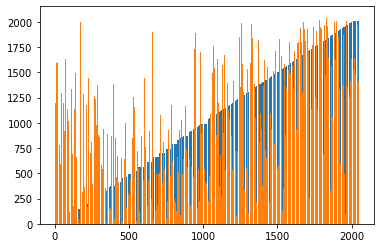

In [164]:
plt.bar(x=df_result.index,height=df_result.rank_norm_Dffclt)
plt.bar(x=df_result.index,height=df_result.rank_PRED_Dffclt)
plt.show()

In [ ]:
loss = nn.MarginRankingLoss()
input1 = torch.tensor([1,0,0])
input2 = torch.tensor([1,1,1])
target = torch.tensor([1,1,1])
output = loss(input1, input2, target)
print(input1)
print(input2)
print(target)
print(output)
# output.backward()

tensor([1, 0, 0])
tensor([1, 1, 1])
tensor([1, 1, 1])
tensor(0.6667)


tensor([0, 0, 0])
tensor([-1,  1,  1])
tensor([1, 1, 1])
tensor(0.6667)


Visualizar lo de ranking correlation